In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

M_PI = 3.14159265358979
N_TO_GRAMS = 101.97162129779  # Conversion factor

# Fixing random state for reproducibility
np.random.seed(19680801)

In [72]:

propThrustFactor_x = -0.00012
propThrustFactor_y = -0.004
propThrustFactor_z = 14.5
maxRPM = 36000
propA = 4.3e-9
propTorqFactor = 0.0037
propInertia = 2.5e-06

motorKV = 1900
motorR = 0.12
motorI0 = 0.55

vbat = 26.0


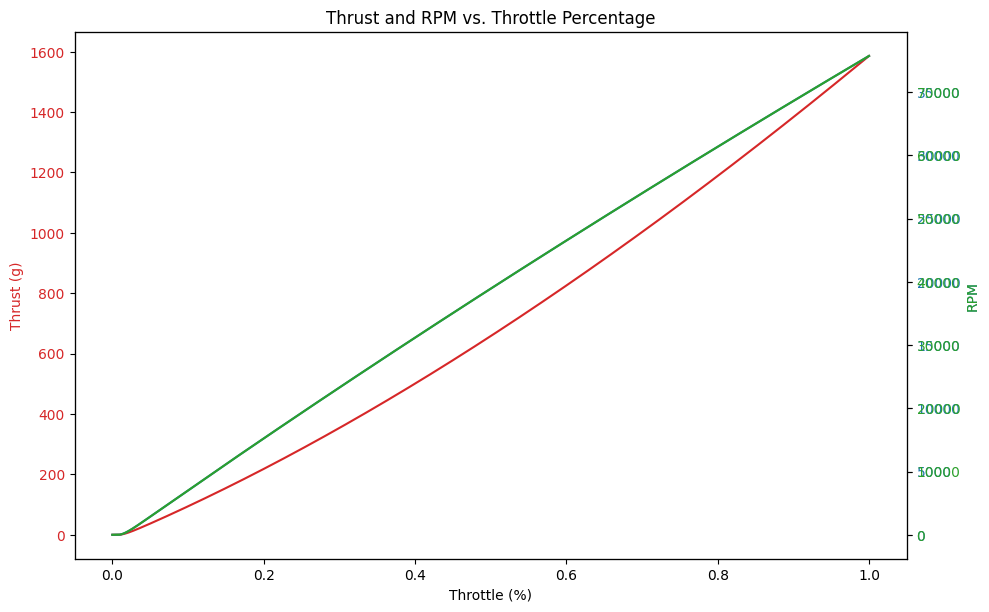

In [76]:
# calc & draw

def rpmToHz(rpm):
  return rpm / 60.0

def oscillation1f(amplitude, frequencyHz, t, phaseShift = 0):
  return amplitude * np.sin(2.0 * np.pi * frequencyHz * t + phaseShift)

def interpolate(x, y, i):
  return x * (1.0 - i) + y * i

output = 0.0

def lowpass(dt, cutoffFrequency, value):
  global output
  ePow = 1.0 - math.exp(-dt * 2.0 * math.pi * cutoffFrequency)
  output += (value - output) * ePow
  return output

def clamp(x, min, max):
  if (x < min):
    return min
  if (x > max):
    return max
  return x

def max(a, b):
  if(a > b):
    return a
  return b


def prop_thrust(rpm, vel):
  # max thrust vs velocity:
  propF = propThrustFactor_x * vel * vel + propThrustFactor_y * vel + propThrustFactor_z
  propF = max(0.0, propF)

  # thrust vs rpm (and max thrust)
  b = (propF - propA * maxRPM * maxRPM) / maxRPM
  result = b * rpm + propA * rpm * rpm

  return np.maximum(result, 0.0)

def prop_torque(rpm, vel):
  return prop_thrust(rpm, vel) * propTorqFactor

def motor_torque(volts, rpm):
  backEmfV = rpm / motorKV
  current = (volts - backEmfV) / (motorR * 3.0)

  if (current > 0):
    current = max(0.0, current - motorI0)
  elif (current < 0):
    current = min(0.0, current + motorI0)

  NmPerA = 8.3 / motorKV
  return current * NmPerA
  #old version:
  #return current * 60 / (motorKV * 2.0 * M_PI)

def motor_current(mTorque):
  return mTorque * motorKV / 8.3


def rpmCurve(throttleArray):
  current_rpm = 0

  rpmList = []
  thrustList = []
  motorTorqueList = []

  for throttleVal in np.nditer(throttleArray):
    pwm  = throttleVal * 1000.0 #+ 1000.0
    rpm = current_rpm

    volts = pwm / 1000.0 * vbat
    
    mtorque = motor_torque(volts, rpm)
    motorTorqueList.append(mtorque)

    ptorque = prop_torque(rpm, 0)
    nettorque = mtorque * 0.833 - ptorque
    domega = nettorque / propInertia

    drpm = (domega * dt) * 60.0 / (2.0 * M_PI)

    maxdrpm = abs(volts * motorKV - rpm)
    rpm += clamp(drpm, -maxdrpm, maxdrpm)

    pthrust= prop_thrust(rpm, 0)

    current_rpm = rpm

    rpmList.append(rpm)
    thrustList.append(pthrust)
  
  return np.array(rpmList), np.array(thrustList), np.array(motorTorqueList)

def setArray(arr, startIndex, endIndex, value):
  l = len(arr)
  for i in range(0, l):
    if i >= startIndex and i < endIndex:
      arr[i] = value


frequency = 20e3
delta = 1e6 / frequency

dt = delta / 1e6

time = 5
maxRpmFull = maxRPM

t = np.arange(0.0, time, dt)

throttle = np.linspace(0, 1, len(t))
#throttle = oscillation1f(0.5, 4, t, -math.pi / 2) + 0.5
#setArray(throttle, time/dt/2, time/dt, 1)


rpmFull = np.linspace(0, maxRpmFull, len(t))

# 345A for 1Nm @3300kv

thrustZeroVel = prop_thrust(rpmFull, 0.0)
rpm, thrust, motorTorque = rpmCurve(throttle)

motorCurrent = motor_current(motorTorque)

constMotorCurrent = motorCurrent[-1]
maxMotorCurrent = np.max(motorCurrent)
maxMotorTorque = np.max(motorTorque)
maxThrustZeroVel = np.max(thrustZeroVel)
maxThrust = np.max(thrust)
maxRpm = np.max(rpm)

thrustInGrams = thrust * N_TO_GRAMS


# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Throttle (%)')
ax1.set_ylabel('Thrust (g)', color=color)
ax1.plot(throttle, thrustInGrams, label='Thrust (g)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('RPM', color=color)
ax2.plot(throttle, rpm, label='RPM', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Thrust and RPM vs. Throttle Percentage')
plt.show()